Images made up of a trillion pixels, known as terapixel images, can effectively present information to stakeholders, but they require a significant amount of computing power. To minimize costs and optimize the process, it is beneficial to use cloud supercomputing infrastructure to analyze the data collected during the production of a terapixel image of Newcastle Upon Tyne. The problem addressed in this situation is how to deliver the necessary supercomputer resources for the computation of this large-scale image. The goal is to examine the data from the application checkpoint and system metric output, in order to improve the cost-efficiency of the process.

In [5]:
import pandas as pd
# from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from matplotlib import pyplot
from pandas import Series
import statistics

from datetime import datetime as dt, date
from dateutil import parser

In [2]:
app_check = pd.read_csv("application-checkpoints.csv")
gpu = pd.read_csv("gpu.csv")
taskxy = pd.read_csv("task-x-y.csv")

In [3]:
app_taskxy = pd.merge(taskxy, app_check, on = ['jobId', 'taskId'], how='left')
app_taskxy_gpu = pd.merge(app_taskxy, gpu, on=['timestamp'])


In [6]:
app_taskxy_gpu = app_taskxy_gpu.loc[:,~app_taskxy_gpu.columns.duplicated()] # deleting duplicate rows...
app_taskxy_gpu["time"] = app_taskxy_gpu["timestamp"].apply(lambda x: parser.isoparse(x))

In [7]:
app_taskxy_gpu.head()

,taskId,jobId,x,y,level,timestamp,hostname_x,eventName,eventType,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
0,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,265232c5f6814768aeefa66a7bec6ff600000Q,323617020812,GPU-f8ed40fb-e2c2-d6e2-9a66-4b6eaae14912,125.89,39,92,60,2018-11-08 08:07:10.688000+00:00
1,00004e77-304c-4fbd-88a1-1346ef947567,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,116,178,12,2018-11-08T08:07:10.688Z,0745914f4de046078517041d70b22fe7000001,Tiling,STOP,0d56a730076643d585f77e00d2d8521a00000Q,325117171574,GPU-d84a1024-9381-c725-3b85-dd7143e64c35,25.91,33,0,0,2018-11-08 08:07:10.688000+00:00
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,START,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
3,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Render,STOP,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
4,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:49.863Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,TotalRender,STOP,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00


What is the interplay between GPU temperature and performance?


In [21]:
start_df = app_taskxy_gpu[app_taskxy_gpu['eventType'] == 'START']
stop_df = app_taskxy_gpu[app_taskxy_gpu['eventType'] == 'STOP']
start_df.rename(
        index=str, columns={"time": "start_time"}, inplace = True)
stop_df.rename(
        index=str, columns={"time": "stop_time"}, inplace = True)

stop_df.drop('eventType', axis = 1, inplace = True)
start_df.drop('eventType', axis = 1, inplace = True)
   
# # Make each field record start and stop combined
   
df = pd.merge( start_df, stop_df, 
            on=['eventName', 'x', 'y', 'level'])


# # Finding the duration
df['duration'] = (df['stop_time'] - df['start_time']).dt.total_seconds()
df


C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  start_df.rename(
C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df.rename(
C:\Users\Ashu\AppData\Local\Temp\ipykernel_11600\2949399360.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stop_df.drop('eventType', axis = 1, inplace = True)
C:\Users\Ashu\AppD

,taskId_x,jobId_x,x,y,level,timestamp_x,hostname_x_x,eventName,hostname_y_x,gpuSerial_x,...,hostname_x_y,hostname_y_y,gpuSerial_y,gpuUUID_y,powerDrawWatt_y,gpuTempC_y,gpuUtilPerc_y,gpuMemUtilPerc_y,stop_time,duration
0,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,8b6a0eebc87b4cb2b0539e81075191b900000U,323617021463,GPU-f955049b-a429-3eed-f7f1-30a072341123,136.61,49,94,55,2018-11-08 08:14:49.863000+00:00,1.008
1,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
2,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
3,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,265232c5f6814768aeefa66a7bec6ff600000T,323617020801,...,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,4ad946d4435c42dabb5073531ea4f31500000Y,320218055700,GPU-a2836c0d-5c10-eff0-4910-9681b4b039a7,128.23,37,93,57,2018-11-08 07:49:18.028000+00:00,0.946
4,000d1def-1478-40d3-a5e3-4f848daee474,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,179,226,12,2018-11-08T08:21:27.481Z,b9a1fa7ae2f74eb68f25f607980f97d700000V,Tiling,b9a1fa7ae2f74eb68f25f607980f97d7000019,324917052134,...,b9a1fa7ae2f74eb68f25f607980f97d700000V,4ad946d4435c42dabb5073531ea4f315000018,325017018095,GPU-6ab2031f-938b-3d9a-fc14-9c9e308d2716,118.93,40,91,46,2018-11-08 08:21:28.583000+00:00,1.102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86628,ecb08d02-79b5-43ef-b58c-b55b4b84e39c,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,12,4,8,2018-11-08T07:42:39.161Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,Uploading,8b6a0eebc87b4cb2b0539e81075191b900001D,323617021151,...,83ea61ac1ef54f27a3bf7bd0f41ecaa700000J,265232c5f6814768aeefa66a7bec6ff6000010,323617020951,GPU-af3d11cb-8a8c-1d21-2906-216f0a3e55ad,34.37,34,1,0,2018-11-08 07:42:40.187000+00:00,1.026
86629,f7b53cc0-d2f1-421b-a7a1-4949ddc38075,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,2,6,8,2018-11-08T07:42:50.906Z,cd44f5819eba427a816e7ce648adceb2000001,Uploading,265232c5f6814768aeefa66a7bec6ff6000001,323217056104,...,cd44f5819eba427a816e7ce648adceb2000001,a77ef58b13ad4c01b769dac8409af3f800000X,323617020586,GPU-9c0266e2-aa48-361b-455e-f5fc6159ee31,83.40,35,82,34,2018-11-08 07:42:51.970000+00:00,1.064
86630,f8559617-7298-4ee0-9742-9e9e7b5f54df,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,14,3,8,2018-11-08T07:43:14.194Z,0d56a730076643d585f77e00d2d8521a00000R,Tiling,6139a35676de44d6b61ec247f0ed8657000018,325017018337,...,0d56a730076643d585f77e00d2d8521a00000R,83ea61ac1ef54f27a3bf7bd0f41ecaa700000X,323617043082,GPU-88356e9f-7159-3ed6-b131-c4bfc506e7e9,94.95,43,89,44,2018-11-08 07:43:15.317000+00:00,1.123
86631,fb9f46a2-a940-4773-996f-6db2204350d2,1024-lvl8-5ad819e1-fbf2-42e0-8f16-a3baca825a63,0,0,8,2018-11-08T07:42:13.045Z,04dc4e9647154250beeee51b866b071500000X,Uploading,04dc4e9647154250beeee51b866b071500000T,323217056004,...,04dc4e9647154250beeee51b866b071500000X,b9a1fa7ae2f74eb68f25f607980f97d700001A,325017017862,GPU-7788192a-b813-3215-3ac6-93f8991b577f,26.70,31,0,0,2018-11-08 07:42:34.016000+00:0

In [19]:
start_df.head()

,taskId,jobId,x,y,level,start_time,hostname_x,eventName,hostname_y,gpuSerial,gpuUUID,powerDrawWatt,gpuTempC,gpuUtilPerc,gpuMemUtilPerc,time
2,0002afb5-d05e-4da9-bd53-7b6dc19ea6d4,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,190,12,2018-11-08T08:14:48.855Z,83ea61ac1ef54f27a3bf7bd0f41ecaa700001A,Uploading,d8241877cd994572b46c861e5d144c8500000W,323617021323,GPU-f5716e40-9e60-f0af-7a7a-95d2fc4d2fd9,102.36,41,92,52,2018-11-08 08:14:48.855000+00:00
7,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:48:46.175Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,TotalRender,dcc19f48bb3445a28338db3a8f002e9c00001C,323617043038,GPU-107fdc0f-36d3-62e5-58e5-b11527010f1c,70.38,44,89,53,2018-11-08 07:48:46.175000+00:00
8,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:48:46.175Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Saving Config,dcc19f48bb3445a28338db3a8f002e9c00001C,323617043038,GPU-107fdc0f-36d3-62e5-58e5-b11527010f1c,70.38,44,89,53,2018-11-08 07:48:46.175000+00:00
11,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,0745914f4de046078517041d70b22fe7000014,325117064385,GPU-3ba7819f-90bf-f33c-cabe-3b1e83d80ca8,48.17,42,0,0,2018-11-08 07:49:17.082000+00:00
12,0003c380-4db9-49fb-8e1c-6f8ae466ad85,1024-lvl12-7e026be3-5fd0-48ee-b7d1-abd61f747705,142,86,12,2018-11-08T07:49:17.082Z,83ea61ac1ef54f27a3bf7bd0f41ecaa7000004,Tiling,8b6a0eebc87b4cb2b0539e81075191b900000T,323617021011,GPU-d93f9cba-097b-3d79-ffea-37e5c10748af,126.39,41,94,51,2018-11-08 07:49:17.082000+00:00


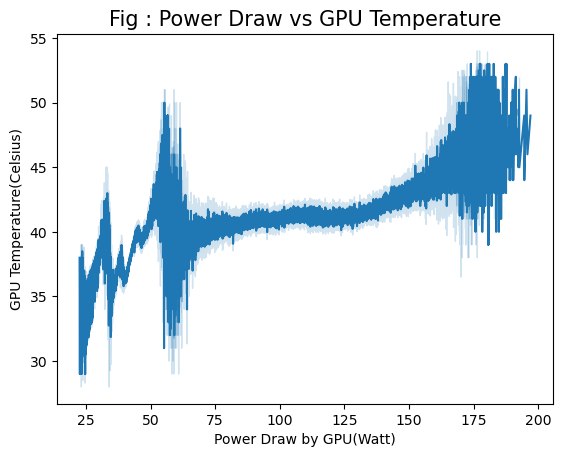

In [11]:
ax = sns.lineplot(data=gpu, x="powerDrawWatt", y="gpuTempC")
plt.xlabel('Power Draw by GPU(Watt)', fontsize = 10)
plt.ylabel('GPU Temperature(Celsius)', fontsize = 10)
plt.title("Fig : Power Draw vs GPU Temperature", fontsize = 15)
plt.show()